# Algorithm 1: Performative Risk Control

### Set up

In [1]:
# Experimental setup arguments

class args:
    alpha = 0.04        # risk control level
    tightness = 0.00    # tightness parameter, may throw error if too low
    delta = 0.05        # failure probability or confidence parameter

    tau = 1.0            # safety parameter
    # L = 5              # Lipschitz constant

    gamma = 0.05        # sensitivity constant, must be <= tau from the theory

    N = 1000            # number of samples in cohort

    lambda_max = 1.0    # maximum value for lambda

    ell_max = 1.0

    # To calculate after the first round
    # delta_lambda      # max difference in lambda between consecutive rounds to guarantee tightness
    # T                 # number of rounds needed for theoretical guarantee
    # sigma_sq          # upper bound on variance on any distributional parameter lambda
    # M             # upper bound on the PDF of the initial data distribution

In [2]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [3]:
# import os
# os.chdir(r'C:\Users\chenbt\Downloads\rcpp-main\rcpp-main\GiveMeSomeCredit')

In [4]:
from collections import Counter
from sklearn.model_selection import train_test_split
from data_prep import load_data

# Set random seed for reproducibility
np.random.seed(42)

# Load data
path_to_csv_file = './data/cs-training.csv'

X_train, Y_train, X_rest, Y_rest, data = load_data(path_to_csv_file, train_size=3000)

# Report full feature dimension
d = X_train.shape[1] - 1
print('d =', d)

# Show class distributions
print("Class distribution in training set:", Counter(Y_train))
print("Class distribution in calibration/test set:", Counter(Y_rest))

d = 10
Class distribution in training set: Counter({np.int64(1): 1500, np.int64(0): 1500})
Class distribution in calibration/test set: Counter({np.int64(0): 110412, np.int64(1): 6857})


In [5]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


[[ 0.75846005 -0.33242949  2.08943911 -0.12555749 -0.87339703 -0.04600031
   2.36632752  0.15007559  0.2260159   0.05496368 -0.22792819]]


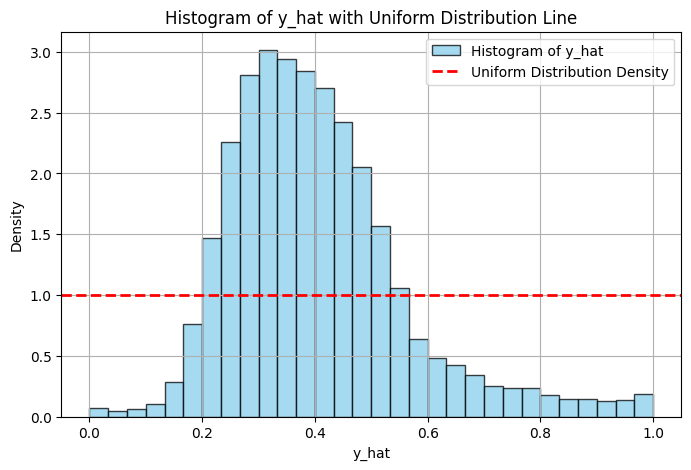

M = 3.0161423735172983


In [6]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)
Y_hat = model.predict_proba(X_rest)[:,1]


# Assuming y_hat is already defined and contains values between 0 and 1
# Example: y_hat = np.random.uniform(0, 1, N)

plt.figure(figsize=(8, 5))

# Plot histogram of y_hat
counts, bins, _ = plt.hist(Y_hat, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.75, label='Histogram of y_hat')

# Overlay horizontal line for uniform distribution
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Uniform Distribution Density')

# Labels and legend
plt.xlabel('y_hat')
plt.ylabel('Density')
plt.title('Histogram of y_hat with Uniform Distribution Line')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Compute M: Upper bound of the PDF
M= counts.max()
print('M =', M)

In [26]:
def hoeffding_bound(T, n):

    # delta_prime = (args.delta * args.tau * epsilon) / (T * args.alpha)
    delta_prime = args.delta / T
    return args.ell_max * np.sqrt((1 / (2 * n)) * np.log(2 / delta_prime))

def DKW_bound(T, n):
    delta_prime = args.delta / T
    return np.sqrt(np.log(2 / delta_prime) / (2 * n))

In [18]:
import numpy as np
from typing import Callable

def beta_cvar(beta: float) -> Callable[[np.ndarray], float]:
    """
    Return a function that computes the β-CVaR of an array x,
    i.e. the mean of the worst (1−β) tail.
    """
    if not (0 <= beta < 1):
        raise ValueError("beta must be in [0,1).")
    def fn(x: np.ndarray) -> float:
        x = np.asarray(x)
        q = np.quantile(x, beta)
        return x[x >= q].mean()
    return fn


def beta_var(beta: float) -> Callable[[np.ndarray], float]:
    """
    Return a function that computes the β-VaR (the β-quantile)
    of an array x by linear interpolation.
    """
    if not (0 <= beta <= 1):
        raise ValueError("beta must be in [0,1].")
    def fn(x: np.ndarray) -> float:
        xs = np.sort(np.asarray(x))
        n = len(xs)
        pos = beta * (n - 1)
        lo = int(np.floor(pos))
        hi = int(np.ceil(pos))
        if lo == hi:
            return xs[lo]
        w = pos - lo
        return (1 - w) * xs[lo] + w * xs[hi]
    return fn


def var_interval(beta_min: float, beta_max: float) -> Callable[[np.ndarray], float]:
    """
    Return a function that computes the (beta_min, beta_max)-VaR interval,
    i.e. the average of all x in the [beta_min, beta_max] empirical quantile window.
    """
    if not (0 <= beta_min < beta_max <= 1):
        raise ValueError("Require 0 ≤ beta_min < beta_max ≤ 1.")
    def fn(x: np.ndarray) -> float:
        x = np.asarray(x)
        q_min = np.quantile(x, beta_min)
        q_max = np.quantile(x, beta_max)
        window = x[(x >= q_min) & (x <= q_max)]
        return window.mean()
    return fn


loss_example = np.linspace(0, 1, 1001)
# average of the worst 10%:
cvar_90 = beta_cvar(0.9)
print(cvar_90(loss_example))

# the 95%-VaR:
var_95 = beta_var(0.95)
print(var_95(loss_example))

# average between the 80% and 90% quantiles:
mid = var_interval(0.8, 0.9)
print(mid(loss_example))

0.9499999999999998
0.9500000000000001
0.8500000000000002


In [19]:
# Hoeffding-benktus bound

def _calc_hoeffding_bentkus_p_value(emp_risk, alpha, N):
    a = min(emp_risk, alpha)
    b = alpha
    # print("emp_risk, alpha: ", emp_risk, alpha)
    entropy = a * np.log(a / b) + (1 - a) * np.log((1 - a) / (1 - b))
    left = np.exp(-N * entropy)
    right = np.exp(1) * stats.binom.cdf(np.ceil(emp_risk * N), N, alpha)
    return min(left, right)

def _get_hoeffding_bentkus_is_width_workable(c, emp_risk, delta_prime, N):
    upper_p_value = _calc_hoeffding_bentkus_p_value(emp_risk, emp_risk + c, N)
    lower_p_value = _calc_hoeffding_bentkus_p_value(1 - emp_risk, 1 - emp_risk + c, N)
    return lower_p_value + upper_p_value <= delta_prime

def hoeffding_bentkus_bound(T, N, alpha, loss_max = 1, tol=1e-5):
    assert loss_max == 1

    delta_prime = args.delta/T
    low_emp_risk, high_emp_risk = tol, alpha
    while low_emp_risk < high_emp_risk - tol:
        mid_emp_risk = (low_emp_risk + high_emp_risk) / 2
        # print(mid_emp_risk)
        if _get_hoeffding_bentkus_is_width_workable(alpha - mid_emp_risk, mid_emp_risk, delta_prime, N):
            low_emp_risk = mid_emp_risk
        else:
            high_emp_risk = mid_emp_risk
    return alpha - low_emp_risk

In [20]:
def _calc_bernstein_bound(delta_prime, N, emp_risk, loss_max = 1):
    p = emp_risk  / loss_max
    max_var = p * (1 - p) * (loss_max ** 2)
    a = (N ** 2) / 2
    b = - N * (loss_max / 2) * np.log(2 / delta_prime) / 3
    c = - np.log(2 / delta_prime) * N * max_var
    return (-b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


def bernstein_bound(T, N, alpha, loss_max = 1, tol=1e-5):
    """
    Same as CLT. Copy-pasted b/c this is research code.
    """
    # Aggregate `_clt_bound` over possible emp_risks.
    # Since _clt_bound is monotonically increasing in `emp_risk` until p=0.5
    # Then it decreases
    delta_prime = args.delta/T
    max_bernstein_bound = _calc_bernstein_bound(delta_prime, N, 0.5 * loss_max, loss_max)
    # The `max_clt_bound` is already sufficient
    if 0.5 * loss_max + max_bernstein_bound < alpha:
        return max_bernstein_bound

    low_emp_risk, high_emp_risk = 0, loss_max * 0.5

    while low_emp_risk < high_emp_risk - tol:
        mid_emp_risk = (low_emp_risk + high_emp_risk) / 2
        confidence_width = _calc_bernstein_bound(delta_prime, N, mid_emp_risk, loss_max)
        ucb = mid_emp_risk + confidence_width
        if ucb > alpha:
            high_emp_risk = mid_emp_risk
        else:
            low_emp_risk = mid_emp_risk
    return confidence_width

In [21]:
import scipy.stats as stats

def calc_clt_bound(T, delta_prime, N, emp_risk, loss_max = 1):
    """
    Calculate confidence width based on the maximum variance possible if the
    risk level is `emp_risk`.
    """
    p = emp_risk  / loss_max
    max_var = 1 / (N - 1) * (p * N * (loss_max - emp_risk) ** 2 + (1 - p) * N * emp_risk ** 2)
    return stats.norm.ppf(1 - delta_prime / 2) * np.sqrt(max_var) / np.sqrt(N)

def clt_bound(T, n, loss_max = 1, tol=1e-5):
    """
    Given `alpha`, calculates the confidence width necessary to ensure risk
    control throughout all deployments of lambda.
    """
    # Aggregate `_clt_bound` over possible emp_risks.
    # Since _clt_bound is monotonically increasing in `emp_risk` until p=0.5
    # Then it decreases
    delta_prime = args.delta/T
    max_clt_bound = calc_clt_bound(T, delta_prime, n, 0.5 * loss_max, loss_max)
    # The `max_clt_bound` is already sufficient
    if 0.5 * loss_max + max_clt_bound < args.alpha:
        return max_clt_bound

    low_emp_risk, high_emp_risk = 0, loss_max * 0.5

    while low_emp_risk < high_emp_risk - tol:
        mid_emp_risk = (low_emp_risk + high_emp_risk) / 2
        confidence_width = calc_clt_bound(T, delta_prime, n, mid_emp_risk, loss_max)
        ucb = mid_emp_risk + confidence_width
        if ucb > args.alpha:
            high_emp_risk = mid_emp_risk
        else:
            low_emp_risk = mid_emp_risk
    return confidence_width

In [22]:
# Search for optimal T
def find_optimal_T(bound_type, max_T=1000):
    best_T = None
    best_result = None

    for T in range(1, max_T + 1):
        if bound_type == "hoeffding":
            c_delta = hoeffding_bound(T, args.N)
        elif bound_type == "hoeffding_bentkus":
            c_delta = hoeffding_bentkus_bound(T, args.N, args.alpha)
        elif bound_type == "bernstein":
            c_delta = bernstein_bound(T, args.N, args.alpha)
        elif bound_type == "clt":
            c_delta = clt_bound(T, args.N)
        delta_lambda = (args.tightness - 2 * c_delta) / (2 * args.tau)

        if delta_lambda <= 0 or delta_lambda >= 1:
            continue  # Invalid Delta_lambda
        #print(delta_lambda * T)

        if T >= args.lambda_max / delta_lambda:
            best_T = T
            break  # Choose the one with minimum T

    print(f"Optimal T for {bound_type}: {best_T}, Delta_lambda: {delta_lambda}")
    return best_T, delta_lambda

# Run the optimization
args.alpha = 0.05
args.tightness = 0.05
args.tau = 0.1
optimal_T, _ = find_optimal_T("clt")
optimal_T

Optimal T for clt: 12, Delta_lambda: 0.08652122007607971


12

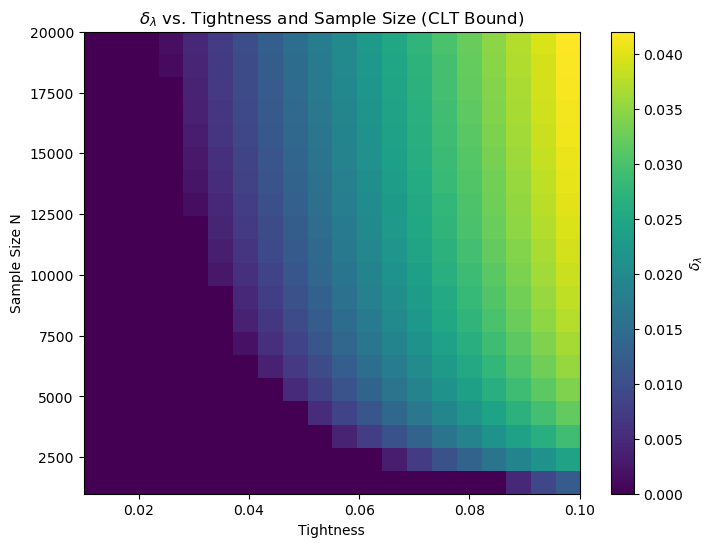

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def compute_delta_lambda(tightness, N, bound_type="clt", max_T=1000):
    original_N = args.N
    original_tightness = args.tightness
    args.N = N
    args.tightness = tightness

    best_T = None
    delta_lambda_result = None

    for T in range(1, max_T + 1):
        if bound_type == "hoeffding":
            c_delta = hoeffding_bound(T, args.N)
        elif bound_type == "hoeffding_bentkus":
            c_delta = hoeffding_bentkus_bound(T, args.N, args.alpha)
        elif bound_type == "bernstein":
            c_delta = bernstein_bound(T, args.N, args.alpha)
        elif bound_type == "clt":
            c_delta = clt_bound(T, args.N)
        else:
            raise ValueError("Invalid bound_type")

        delta_lambda = (args.tightness - 2 * c_delta) / (2 * args.tau)
        if delta_lambda <= 0 or delta_lambda >= 1:
            continue

        if T >= args.lambda_max / delta_lambda:
            best_T = T
            delta_lambda_result = delta_lambda
            break

    args.N = original_N
    args.tightness = original_tightness
    return delta_lambda_result if delta_lambda_result is not None else 0

tightness_vals = np.linspace(0.01, 0.1, 20)
N_vals = np.linspace(1000, 20000, 20, dtype=int)

delta_matrix = np.zeros((len(N_vals), len(tightness_vals)))

for i, N in enumerate(N_vals):
    for j, tightness in enumerate(tightness_vals):
        delta_matrix[i, j] = compute_delta_lambda(tightness, N, bound_type="clt")

plt.figure(figsize=(8, 6))
plt.imshow(delta_matrix, aspect='auto', origin='lower',
           extent=[tightness_vals[0], tightness_vals[-1], N_vals[0], N_vals[-1]],
           cmap='viridis')
plt.colorbar(label=r'$\delta_\lambda$')
plt.xlabel('Tightness')
plt.ylabel('Sample Size N')
plt.title(r'$\delta_\lambda$ vs. Tightness and Sample Size (CLT Bound)')
plt.show()

In [26]:
def find_minimum_N_for_tightness(tightness_target=0.05, 
                                  bound_type="clt", 
                                  max_T=1000, 
                                  N_range=(500, 30000, 500)):
    Ns = range(*N_range)
    feasible_N = None

    original_N = args.N
    original_tightness = args.tightness

    args.tightness = tightness_target

    for N in Ns:
        args.N = N
        try:
            T, delta_lambda = find_optimal_T(bound_type, max_T=max_T)
            if T is not None and delta_lambda > 0:
                feasible_N = N
                break
        except:
            continue  # In case any numerical errors arise

    args.N = original_N
    args.tightness = original_tightness

    return feasible_N

N_required = find_minimum_N_for_tightness(tightness_target=0.05, bound_type="clt")
print(f"Minimum N needed for tightness ≈ 0.05 under CLT bound: {N_required}")

Minimum N needed for tightness ≈ 0.05 under CLT bound: 4000


# Experiment

In [23]:
def type_II_error(Y, Y_proba, threshold):
    """Y=actual, Y_proba=predicted probability, threshold=threshold"""
    return np.mean((Y == 1) * (Y_proba < 1. - threshold))


def piecewise_fn(Y_proba: np.ndarray, thresh: int):
    # clipping assumes loss btwn 0 and 1

    # lower_bound = (1 - thresh) - 1 / args.L
    # upper_bound = 1 - thresh
    # y = np.where(Y_proba < lower_bound, 1, 
    #              np.where(Y_proba > upper_bound, 0, 
    #                       1 - args.L * (Y_proba - (1 - thresh) + 1 / args.L)))

    # Optimization 1: use np.clip
    assert len(Y_proba.shape) == 1
    return np.clip(1. - args.L * (Y_proba - (1 - thresh)), 0, 1)

    # Optimization 2: compute less
    #assert len(Y_proba.shape) == 1
    #return np.clip(args.L * (1 - thresh - Y_proba), 0, 1)


def piecewise_loss(Y, Y_proba, thresh):
    assert len(Y.shape) == 1
    assert len(Y_proba.shape) == 1
    return ((Y == 1) * piecewise_fn(Y_proba, thresh))

def modify(Y_proba, threshold):
    shift = args.gamma / M
    condition = (1 - threshold) < (Y_proba - shift)

    Y_proba_new = Y_proba.copy()
    Y_proba_new[~condition] -= shift
    Y_proba_new = np.clip(Y_proba_new, 0, 1)

    return Y_proba_new

In [24]:
def binary_search_solver(objective, lam_low, lam_high, tol=1e-6, max_iter=100):
    if objective(lam_low) <= 0:
        return lam_low
    
    if objective(lam_high) > 0:
        raise ValueError("No crossing found: objective > 0 for all λ in [lam_low, lam_high].")

    for _ in range(max_iter):
        mid = (lam_low + lam_high) / 2.0
        if objective(mid) <= 0:
            lam_high = mid
        else:
            lam_low = mid
        if lam_high - lam_low < tol:
            break
    return lam_high

In [25]:
def grid_search_solver(objective, lam_low, lam_high, num_points=100):
    lambdas = np.linspace(lam_low, lam_high, num_points)
    for lam in lambdas:
        if objective(lam) <= 0:
            return lam
    raise ValueError("No crossing found: objective > 0 for all λ in [lam_low, lam_high].")

In [27]:
from tqdm import tqdm

def run_trajectory(Y, Y_proba, bound_type, quantile_fn, verbose=False):
    # Precompute bound
    if bound_type == "hoeffding":
        args.T, args.delta_lambda = find_optimal_T(bound_type)
        args.bound = hoeffding_bound(args.T, args.N)
    elif bound_type == "dkw":
        args.bound = DKW_bound(args.T, args.N)
    elif bound_type == "hoeffding_bentkus":
        args.T, args.delta_lambda = find_optimal_T(bound_type)
        args.bound = hoeffding_bentkus_bound(args.T, args.N, args.alpha)
    elif bound_type == "clt":
        args.T, args.delta_lambda = find_optimal_T(bound_type)
        args.bound = clt_bound(args.T, args.N)
    elif bound_type == "bernstein":
        args.T, args.delta_lambda = find_optimal_T(bound_type)
        args.bound = bernstein_bound(args.T, args.N, args.alpha)
    else:
        raise ValueError(f"Unknown bound_type: {bound_type}")

    # Initialization
    thresh = args.lambda_max
    threshes = [thresh]

    # Metrics
    # loss_at_lambda_t = []
    err_at_lambda_t = []
    # loss_at_lambda_tp1 = []
    err_at_lambda_tp1 = []

    iters = tqdm(range(1, args.T + 1)) if verbose else range(1, args.T + 1)
    # args.N = 1000 Number of samples per iteration

    ### === NEW PART: prepare global indices without replacement ===
    total_size = len(Y)
    #assert n_sample * args.T <= total_size, "Not enough samples for no-replacement sampling! Reduce T or sample size."

    all_indices = np.random.permutation(total_size)  # Shuffle once
    pointer = 0  # Pointer to track where we are

    for t in iters:
        # Deploy threshold
        Y_proba_t = modify(Y_proba, thresh)


        # === Take a fresh batch without global repeats ===
        idx = all_indices[pointer: pointer + args.N]
        pointer += args.N  # Move pointer for next iteration

        Y_sample = Y[idx]
        Y_proba_sample = Y_proba_t[idx]

        # Calculate loss and error
        # loss_t = float(np.mean(piecewise_loss(Y_sample, Y_proba_sample, thresh)))
        err_t = float(type_II_error(Y_sample, Y_proba_sample, thresh))
        # loss_at_lambda_t.append(loss_t)
        err_at_lambda_t.append(err_t)

        # Update threshold
        func = lambda nt: quantile_fn(type_II_error(Y_sample, Y_proba_sample, nt)) + args.tau * (thresh - nt) + args.bound - args.alpha
        mid_thresh = binary_search_solver(func, 0, 1)
        new_thresh = min(mid_thresh, thresh)

        # Evaluate new threshold
        # loss_tp1 = float(np.mean(piecewise_loss(Y_sample, Y_proba_sample, new_thresh)))
        err_tp1 = float(type_II_error(Y_sample, Y_proba_sample, new_thresh))
        # loss_at_lambda_tp1.append(loss_tp1)
        err_at_lambda_tp1.append(err_tp1)

        if new_thresh > thresh - args.delta_lambda:
            threshes.append(new_thresh)
            stopping_iter = t
            break

        thresh = new_thresh
        threshes.append(thresh)

    return {
        "Stopping iteration": stopping_iter,
        #"loss_at_lambda_t": loss_at_lambda_t,
        "err_at_lambda_t": err_at_lambda_t,
        #"loss_at_lambda_tp1": loss_at_lambda_tp1,
        "err_at_lambda_tp1": err_at_lambda_tp1,
        "threshes": threshes
    }

### Run

In [28]:
X_cal, X_test, Y_cal, Y_test = train_test_split(
    X_rest, Y_rest, train_size=10000, random_state=42
)
Y_proba = model.predict_proba(X_cal)[:,1]

### plot 1: change gamma, i.e. magnitude of distribution shift

In [30]:
gammas = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
results_1 = {}
quantile_fn = beta_cvar(0.9)  # Example quantile function

for gamma in gammas:
    args.gamma = gamma

    # Run PRC
    output = run_trajectory(Y_cal, Y_proba, "clt", quantile_fn, verbose=True)

    results_1[gamma] = {
        #"loss_at_lambda_t": output["loss_at_lambda_t"],
        #"loss_at_lambda_tp1": output["loss_at_lambda_tp1"],
        "err_at_lambda_t": output["err_at_lambda_t"],
        "err_at_lambda_tp1": output["err_at_lambda_tp1"],
        "threshes": output["threshes"],
    }

Optimal T for clt: 12, Delta_lambda: 0.08652122007607971


 25%|██▌       | 3/12 [00:00<00:00, 296.45it/s]


Optimal T for clt: 12, Delta_lambda: 0.08652122007607971


 17%|█▋        | 2/12 [00:00<00:00, 256.01it/s]


Optimal T for clt: 12, Delta_lambda: 0.08652122007607971


 25%|██▌       | 3/12 [00:00<00:00, 300.57it/s]


Optimal T for clt: 12, Delta_lambda: 0.08652122007607971


 17%|█▋        | 2/12 [00:00<00:00, 256.82it/s]


Optimal T for clt: 12, Delta_lambda: 0.08652122007607971


 17%|█▋        | 2/12 [00:00<00:00, 265.29it/s]


Optimal T for clt: 12, Delta_lambda: 0.08652122007607971


 17%|█▋        | 2/12 [00:00<00:00, 260.18it/s]


Optimal T for clt: 12, Delta_lambda: 0.08652122007607971


 25%|██▌       | 3/12 [00:00<00:00, 305.00it/s]


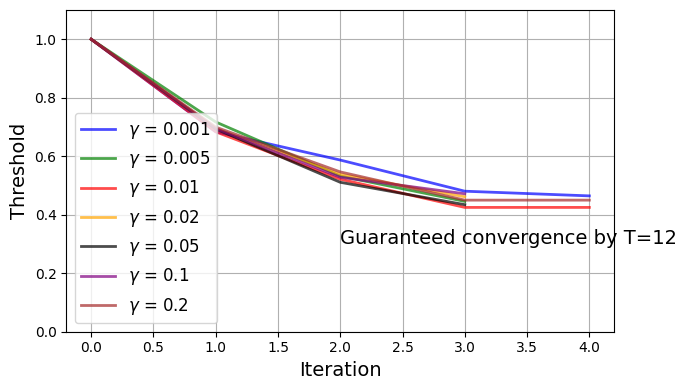

In [31]:
plt.figure(figsize=(7, 4))
plt.ylim(0, args.lambda_max)

colors = ['blue', 'green', 'red', 'orange', 'black', 'purple', 'brown']

for gamma, color in zip(gammas, colors):
    plt.plot(results_1[gamma]["threshes"], label=rf"$\gamma$ = {gamma}", color=color, alpha=0.7, linewidth=2)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Threshold', fontsize=14)
plt.ylim(0, 1.1)
plt.text(2, 0.3, f"Guaranteed convergence by T={args.T}", fontsize=14)
plt.legend(fontsize=12, loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

Smaller $\gamma$: Requires more iterations due to mild distribution shift, allowing gradual threshold adjustment.

Larger  $\gamma$: Causes infeasibility as the shift is too large, empirical loss is high in the first iteration, and no threshold satisfies the algorithm's condition.
.


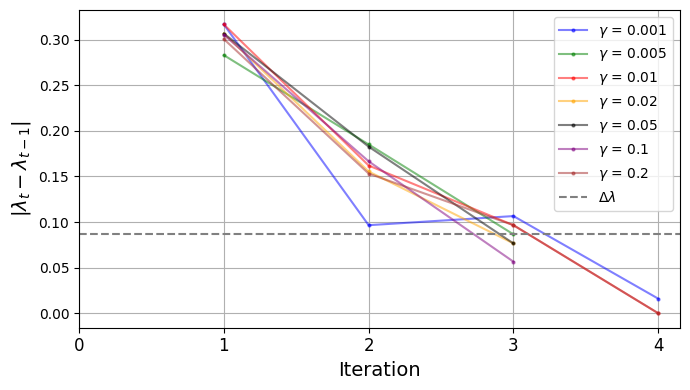

In [32]:
plt.figure(figsize=(7, 4))

num_iters = 0

for gamma, color in zip(gammas, colors):
    threshes = results_1[gamma]["threshes"]
    diffs = [np.abs(threshes[i] - threshes[i - 1]) for i in range(1, len(threshes))]
    if len(diffs) > num_iters:
        num_iters = len(diffs)
    
    # Normalize to start from 1
    if diffs[0] > 0:
        normalized_diffs = [diff / diffs[0] for diff in diffs]
        normalized_delta_lambda = args.delta_lambda / diffs[0]  # Normalize delta_lambda
        plt.plot(range(1, len(threshes)), diffs, marker='o', markersize=2,
                 label=rf"$\gamma$ = {gamma}", color=color, alpha = 0.5)

plt.axhline(y=args.delta_lambda, color='gray', linestyle='--', linewidth=1.5, label=rf"$\Delta\lambda$")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel(r'$|\lambda_t - \lambda_{t-1}|$', fontsize=14)
plt.xticks(ticks=range(num_iters + 1), labels=[str(i) for i in range(num_iters + 1)], fontsize=12)
#plt.ylim(0,1.1)
#plt.title('Normalized Squared Threshold Differences')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

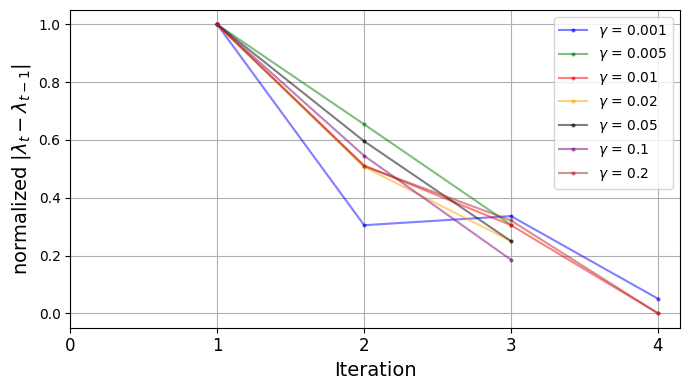

In [33]:
plt.figure(figsize=(7, 4))

for gamma, color in zip(gammas, colors):
    threshes = results_1[gamma]["threshes"]
    # Compute squared diffs between successive thresholds
    diffs = [np.abs(threshes[i] - threshes[i - 1]) for i in range(1, len(threshes))]
    
    # Normalize to start from 1
    if diffs[0] > 0:
        normalized_diffs = [diff / diffs[0] for diff in diffs]
        normalized_delta_lambda = args.delta_lambda / diffs[0]  # Normalize delta_lambda
        plt.plot(range(1, len(threshes)), normalized_diffs, marker='o', markersize=2,
                 label=rf"$\gamma$ = {gamma}", color=color, alpha = 0.5)

#plt.axhline(y=args.delta_lambda, color='gray', linestyle='--', linewidth=1.5, label=rf"$\Delta\lambda$")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel(r'normalized $ |\lambda_t - \lambda_{t-1}|$', fontsize=14)
plt.xticks(ticks=range(num_iters + 1), labels=[str(i) for i in range(num_iters + 1)], fontsize=12)
#plt.ylim(0,1.1)
#plt.title('Normalized Squared Threshold Differences')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### plot 2: Plot risk level vs. num of iter. $E_{D(\lambda_t)} l(\lambda_{t+1})$  (avg over 1000 trajectories+err bar). 

In [34]:
args.gamma = 0.2

In [37]:
num_runs = 1000
#all_losses_tp1 = []
all_errs_tp1 = []
#all_losses_t = []
all_errs_t = []

all_accuracies_per_iter = []
all_threshes = None 

# Step 1: Split calibration/test
#X_cal, X_test, Y_cal, Y_test = train_test_split(
#        X_temp, Y_temp, train_size=10000, random_state=42
#    )

quantile_fn = beta_cvar(0.9)  # Example quantile function

for seed in range(num_runs):
    # Step 2: Predict probabilities
    Y_proba_cal = model.predict_proba(X_cal)[:, 1]
    Y_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Step 3: Run PRC
    results_2 = run_trajectory(Y_cal, Y_proba_cal, "clt", quantile_fn)

    # Save results
    #all_losses_tp1.append(results_2["loss_at_lambda_tp1"])
    all_errs_tp1.append(results_2["err_at_lambda_tp1"])
    #all_losses_t.append(results_2["loss_at_lambda_t"])
    all_errs_t.append(results_2["err_at_lambda_t"])

Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_la

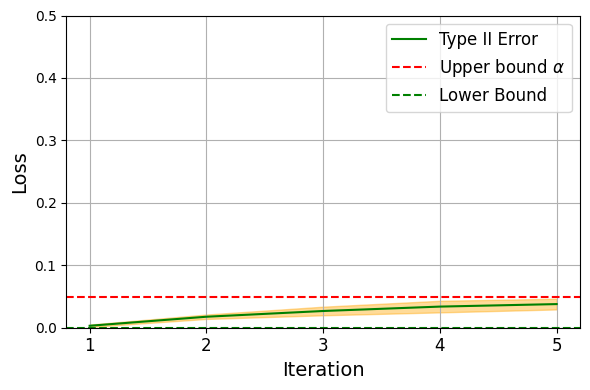

In [38]:
max_len = max(len(l) for l in all_errs_tp1)

#loss_matrix = np.array([
#    np.pad(l, (0, max_len - len(l)), constant_values=np.nan)
#    for l in all_losses_tp1
#])

err_matrix = np.array([
    np.pad(e, (0, max_len - len(e)), constant_values=np.nan)
    for e in all_errs_tp1
])

#loss_mean = np.nanmean(loss_matrix, axis=0)
#loss_std = np.nanstd(loss_matrix, axis=0)

err_mean = np.nanmean(err_matrix, axis=0)
err_std = np.nanstd(err_matrix, axis=0)

z = 1.645  # for ~90% confidence
#loss_upper = loss_mean + z * loss_std
#loss_lower = loss_mean - z * loss_std

err_upper = err_mean + z * err_std
err_lower = err_mean - z * err_std

plt.figure(figsize=(6, 4))

# Plot mean trajectories
#plt.plot(loss_mean, color='red', label='Empirical Loss')
plt.plot(err_mean, color='green', label='Type II Error')

# Confidence bands
#plt.fill_between(range(len(loss_mean)), loss_lower, loss_upper, color='b', alpha=0.4)
plt.fill_between(range(len(err_mean)), err_lower, err_upper, color='orange', alpha=0.4)

# Reference lines
plt.axhline(args.alpha, linestyle='--', color='red', label='Upper bound $\\alpha$')
plt.axhline(args.alpha - args.tightness, linestyle='--', color='green', label='Lower Bound')

plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Set x-axis to show 1-based iteration numbers
num_iters = len(err_mean)
plt.xticks(ticks=range(num_iters), labels=[str(i+1) for i in range(num_iters)], fontsize=12)
plt.ylim(0, 0.5)
plt.legend(fontsize=12)
#plt.title("One-Step Lookahead Risk & Error (90% CI)")
plt.grid(True)
plt.tight_layout()
plt.show()

### plot 3: Plot risk level vs. num of iter. $E_{D(\lambda_t)} l(\lambda_{t})$ (avg over 1000 trajectories+err bar)

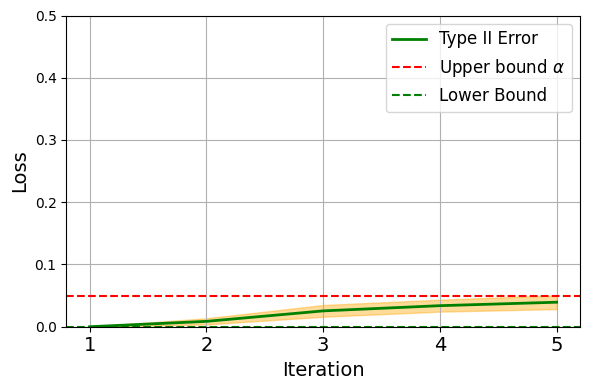

In [74]:
# max_len = max(len(l) for l in all_losses_t)

# Pad to same length for aggregation
#loss_matrix = np.array([
#    np.pad(l, (0, max_len - len(l)), constant_values=np.nan)
#    for l in all_losses_t
#])
err_matrix = np.array([
    np.pad(e, (0, max_len - len(e)), constant_values=np.nan)
    for e in all_errs_t
])

# Compute mean and 90% confidence intervals
#loss_mean = np.nanmean(loss_matrix, axis=0)
#loss_std = np.nanstd(loss_matrix, axis=0)

err_mean = np.nanmean(err_matrix, axis=0)
err_std = np.nanstd(err_matrix, axis=0)

z = 1.645  # for ~90% confidence
#loss_upper = loss_mean + z * loss_std
#loss_lower = loss_mean - z * loss_std

err_upper = err_mean + z * err_std
err_lower = err_mean - z * err_std

# Plotting
plt.figure(figsize=(6, 4))

# Mean curves
# plt.plot(loss_mean, color='red', label='Empirical Loss', linewidth=2)      
plt.plot(err_mean, color='green', label='Type II Error', linewidth=2)         

# Confidence bands
# plt.fill_between(range(len(loss_mean)), loss_lower, loss_upper, color='blue', alpha=0.4)  
plt.fill_between(range(len(err_mean)), err_lower, err_upper, color='orange', alpha=0.4)    

# Reference bounds
plt.axhline(args.alpha, linestyle='--', color='red', label='Upper bound $\\alpha$')
plt.axhline(args.alpha - args.tightness, linestyle='--', color='green', label='Lower Bound')

# Labels and layout
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
# Set x-axis to show 1-based iteration numbers
num_iters = len(err_mean)
plt.xticks(ticks=range(num_iters), labels=[str(i+1) for i in range(num_iters)], fontsize=14)
plt.ylim(0, 0.5)
plt.legend(fontsize=12)
#plt.title("Performative Risk & Error at λ_t (90% CI)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot 4: We get for lambda_T actual value +- err and upper (alpha) and lower bound $E_{D(\lambda_T)}l (\lambda_T)$ 

In [75]:
def evaluate_prc_over_seeds(X_cal, Y_cal, X_test, Y_test, bound_type, num_runs=1000):
    #all_test_losses = []
    all_test_errors = []
    all_final_thresholds = []
    all_stopping_iters = []

    # Step 1: Split calibration/test
    #X_cal, X_test, Y_cal, Y_test = train_test_split(
    #        X_temp, Y_temp, train_size=10000, random_state=42
    #    )

    for seed in range(num_runs):
        # Step 2: Predict probabilities
        Y_proba_cal = model.predict_proba(X_cal)[:, 1]
        Y_proba_test = model.predict_proba(X_test)[:, 1]

        # Step 3: Run PRC
        results_3 = run_trajectory(Y_cal, Y_proba_cal, bound_type)
        final_thresh = results_3["threshes"][-1]
        stopping_iter = results_3["Stopping iteration"]
        all_stopping_iters.append(stopping_iter)
        
        # Step 4: Evaluate on test set (simulate D(λ_T) using final_thresh) 
        Y_proba_test_mod = modify(Y_proba_test, final_thresh)

        # Step 5: Evaluate test loss and error under D(λ_T)
       # test_loss = float(np.mean(piecewise_loss(Y_test, Y_proba_test_mod, final_thresh)))
        test_error = float(type_II_error(Y_test, Y_proba_test_mod, final_thresh))

        # Step 6: Store results
        #all_test_losses.append(test_loss)
        all_test_errors.append(test_error)
        all_final_thresholds.append(final_thresh)

    # Compute statistics and bound
    #losses = np.array(all_test_losses)
    errors = np.array(all_test_errors)

    return {
    #"losses": losses,
    "errors": errors,
    "thresholds": all_final_thresholds,
    "stopping_iters": all_stopping_iters
}

In [76]:
results_3 = evaluate_prc_over_seeds(X_cal, Y_cal, X_test, Y_test, bound_type="clt")

Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_lambda: 0.08652122007607971
Optimal T for clt: 12, Delta_la

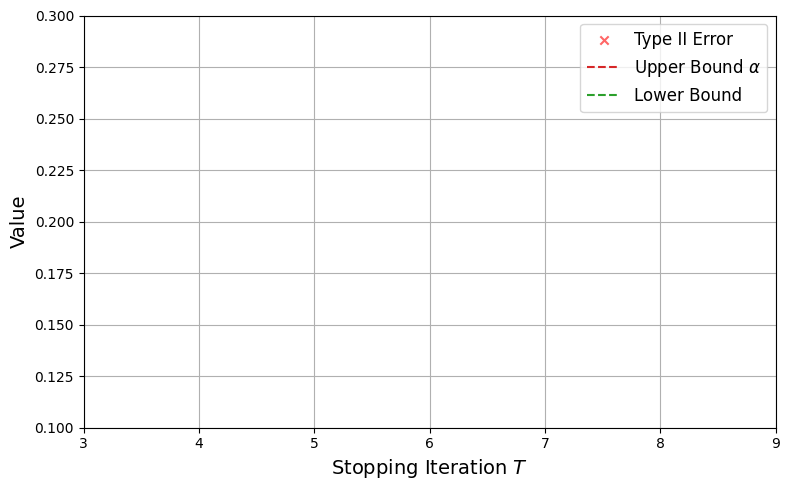

Percentage of Type II Error inside bounds: 100.00%


In [77]:
# Extract values
T_vals = np.array(results_3["stopping_iters"])
#loss_vals = np.array(results_3["losses"])
error_vals = np.array(results_3["errors"])

plt.figure(figsize=(8, 5))

# Plot T vs Loss
# plt.scatter(T_vals, loss_vals, color='blue', label='Loss', alpha=0.6, marker='o')

# Plot T vs Error
plt.scatter(T_vals, error_vals, color='red', label='Type II Error', alpha=0.6, marker='x')

# Plot upper and lower bound
plt.axhline(args.alpha, linestyle='--', color='#d62728', label=r'Upper Bound $\alpha$', linewidth=1.5)  # red
plt.axhline(args.alpha - args.tightness, linestyle='--', color='#2ca02c', label=r'Lower Bound', linewidth=1.5)  # green

plt.xlabel("Stopping Iteration $T$", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xlim(3, 9)
plt.ylim(0.1,0.3)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
#plt.title("Scatter Plot of Loss and Type II Error vs Stopping Iteration", fontsize=14)
plt.show()

# Define bounds
upper_bound = args.alpha
lower_bound = args.alpha - args.tightness

# Calculate percentage inside the bounds
# loss_inside = np.logical_and(loss_vals >= lower_bound, loss_vals <= upper_bound)
error_inside = np.logical_and(error_vals >= lower_bound, error_vals <= upper_bound)

# loss_inside_percentage = 100 * np.mean(loss_inside)
error_inside_percentage = 100 * np.mean(error_inside)

# print(f"Percentage of Loss inside bounds: {loss_inside_percentage:.2f}%")
print(f"Percentage of Type II Error inside bounds: {error_inside_percentage:.2f}%")

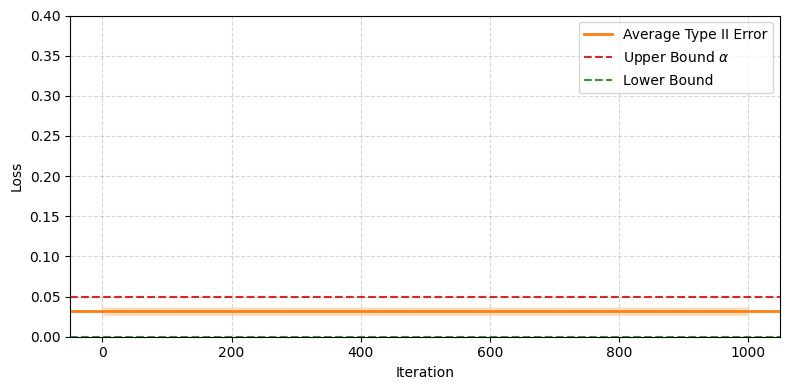

In [78]:
# Extract data from results
# losses = results_3["losses"]
errors = results_3["errors"]

# Compute mean and std
# loss_mean = np.mean(losses)
# loss_std = np.std(losses, ddof=1)

error_mean = np.mean(errors)
error_std = np.std(errors, ddof=1)

# 90% confidence interval
z = 1.645
# loss_upper = loss_mean + z * loss_std
# loss_lower = loss_mean - z * loss_std

error_upper = error_mean + z * error_std
error_lower = error_mean - z * error_std

# Risk thresholds
alpha_line = args.alpha
tight_line = args.alpha - args.tightness

# Plotting
plt.figure(figsize=(8, 4))

# Loss with confidence band (dark blue line, light blue band)
# plt.axhline(loss_mean, color='#1f77b4', label='Average Empirical Loss', linewidth=2)
# plt.fill_between(range(len(losses)), loss_lower, loss_upper, color='#aec7e8', alpha=0.4)

# Error with confidence band (dark orange line, light orange band)
plt.axhline(error_mean, color='#ff7f0e', label='Average Type II Error', linewidth=2)
plt.fill_between(range(len(errors)), error_lower, error_upper, color='#ffbb78', alpha=0.4)

# Threshold lines
plt.axhline(alpha_line, linestyle='--', color='#d62728', label=r'Upper Bound $\alpha$', linewidth=1.5)  # red
plt.axhline(tight_line, linestyle='--', color='#2ca02c', label=r'Lower Bound', linewidth=1.5)  # green

# Aesthetics
#plt.title("Mean Test Loss and Type II Error with 90% Confidence")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim(0,0.4)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Table: Compare $B (N,\delta’)$, i.e. the union bound obtained by different upper bounding techniques

In [68]:
args.tightness = 0.15

In [70]:
bounds = {
    "hoeffding": hoeffding_bound,
    "hoeffding_bentkus": hoeffding_bentkus_bound,
    "clt": clt_bound,
    "bernstein": bernstein_bound
}

for name, bound_fn in bounds.items():
    results = evaluate_prc_over_seeds(X_cal, Y_cal, X_test, Y_test, name)
    errors = results["errors"]

    # Print results
    # print(f"{name} Bound - Test Loss: mean = {np.mean(losses):.4f}, std = {np.std(losses):.4f}")
    print(f"{name} Bound - Type II Error: mean = {np.mean(errors):.4f}, std = {np.std(errors):.4f}")
    print("-" * 60)

hoeffding Bound - Type II Error: mean = 0.1479, std = 0.0099
------------------------------------------------------------
hoeffding_bentkus Bound - Type II Error: mean = 0.1668, std = 0.0110
------------------------------------------------------------
clt Bound - Type II Error: mean = 0.1715, std = 0.0107
------------------------------------------------------------
bernstein Bound - Type II Error: mean = 0.1638, std = 0.0112
------------------------------------------------------------
